In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as ss
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
EPS = 1.e-5

# 1 a

Задача:

\begin{equation*}
 \begin{cases}
   c^Tx \to min\\
   Ax = b\\
   x \ge 0
 \end{cases}
\end{equation*}

Лагранжиан:

$
L(x, \lambda, \mu) = c^Tx + \lambda^T(Ax-b) - \mu^Tx
$

Двойственная функция:

\begin{equation*}
 q(\lambda, \mu) = \begin{cases}
   -\infty, & c+A^T\lambda \neq \mu\\
   -\lambda^Tb, & c+A^T\lambda = \mu
 \end{cases}
\end{equation*}

Двойственная задача:

\begin{equation*}
 \begin{cases}
   -\lambda^Tb \to max\\
   c+A^T\lambda = \mu\\
   \mu \ge 0
 \end{cases}
\end{equation*}

In [3]:
def task1a(A, b, c):
    lamb = cp.Variable(b.size)
    mu = cp.Variable(c.size)
    objective = cp.Maximize(-lamb.T @ b)
    constraints = [mu >= 0, c + A.T @ lamb - mu == 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    x = constraints[0].dual_value
    # print("status:", prob.status)
    return lamb.value, mu.value, x

def task1_test(A, b, c):
    x = cp.Variable(c.size)
    objective = cp.Minimize(c.T @ x)
    constraints = [x >= 0, A @ x == b]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    # print("status:", prob.status)
    return constraints[1].dual_value, constraints[0].dual_value, x.value

In [4]:
A = np.array([[5, 2, 8], [9, 10, -4]])
c = np.array([1, 2, 3])
b = np.array([3, 4])

In [5]:
lamb1, mu1, x1 = task1a(A, b, c)
lamb1, mu1, x1

(array([-0.33695652,  0.07608695]),
 array([-4.64355377e-09,  2.08695651e+00,  2.55313704e-08]),
 array([4.78260869e-01, 5.05754133e-10, 7.60869567e-02]))

In [6]:
lamb2, mu2, x2 = task1_test(A, b, c)
lamb2, mu2, x2

(array([-0.33695652,  0.07608696]),
 array([8.77544029e-11, 2.08695652e+00, 1.50328644e-09]),
 array([4.78260870e-01, 1.38853631e-11, 7.60869565e-02]))

In [7]:
assert(np.all(np.isclose(np.hstack((lamb1, mu1, x1)), np.hstack((lamb2, mu2, x2)), atol=1.e-6)))

In [8]:
np.random.seed(0)
for i in range(100):
    n1, n2 = np.random.randint(2, 15, size=2)
    A = np.random.random_sample((n1, n2))
    b = np.random.random_sample(n1)
    c = np.random.random_sample(n2)

    assert np.all(np.isclose(np.hstack(task1a(A, b, c)).astype(float), np.hstack(task1_test(A, b, c)).astype(float),
                             atol=EPS, equal_nan=True))

# 1 b

часть $x_i \neq 0$ (соответствующие $\mu_i = 0$) - из условий ККТ.

для этой части воспользуемся аналитической формулой точного решения. $x=(A^TA)^{-1}A^Tb$

In [9]:
def task1b(A, b, mu):
    A_ = A[:, mu < EPS]
    x = np.zeros(mu.size)
    x[mu < EPS] = (np.linalg.inv(A_.T @ A_) @ A_.T @ b.reshape(-1, 1)).flatten()
    return x

In [10]:
A = np.array([[5, 2, 8], [9, 10, -4]])
c = np.array([1, 2, 3])
b = np.array([3, 4])

In [11]:
lamb1, mu1, x1 = task1a(A, b, c)
lamb1, mu1, x1

(array([-0.33695652,  0.07608695]),
 array([-4.64355377e-09,  2.08695651e+00,  2.55313704e-08]),
 array([4.78260869e-01, 5.05754133e-10, 7.60869567e-02]))

In [12]:
x1_b = task1b(A, b, mu1)

In [13]:
assert np.all(np.isclose(x1, x1_b))

# 2

In [14]:
def task2(xs):
    center = cp.Variable(xs.shape[1])
    rad_square = cp.Variable(1)
    objective = cp.Minimize(rad_square)
    constraints = [cp.sum_squares(xs[i] - center) <= rad_square for i in range(xs.shape[0])]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return center.value, np.sqrt(rad_square.value)

In [15]:
def task2_print(xs, center, rad):
    plt.plot(*zip(*xs), marker='o', color='g', ls='')
    plt.plot(*center, marker='o', color='y')
    circle = plt.Circle(center, rad, color='r', fill=False)
    ax=plt.gca()
    ax.add_patch(circle)
    plt.axis('scaled')
    plt.show()

In [16]:
xs = np.array([[1,2,3], [2,3,4]])
task2(xs)

(array([1.5, 2.5, 3.5]), array([0.8660254]))

In [17]:
xs = np.array([[0, 4], [0, 1], [4, 2]])
center, rad = task2(xs)
center, rad

(array([1.75, 2.5 ]), array([2.30488611]))

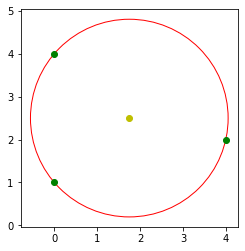

In [18]:
task2_print(xs, center, rad)

In [19]:
xs = np.array([[3, 3], [0, 1], [4, 2]])
center, rad = task2(xs)
center, rad

(array([2.00000586, 1.49997657]), array([2.06155281]))

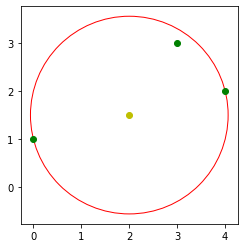

In [20]:
task2_print(xs, center, rad)

In [21]:
xs = np.random.randint(100, size=(100, 2))

[49.96812156 55.26751736] [63.44760268]


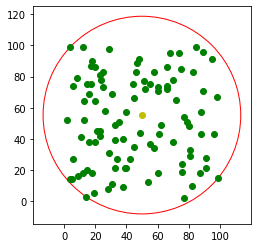

In [22]:
center, rad = task2(xs)
print(center, rad)
task2_print(xs, center, rad)

# 3

In [23]:
def task3(xs, ys):
    x0 = xs[ys==0].T
    x1 = xs[ys==1].T
    assert x0.size + x1.size == xs.size and x0.size > 0 and x1.size > 0
    a = cp.Variable((xs.shape[1], 1))
    objective = cp.Minimize(cp.max(a.T @ x1) - cp.min(a.T @ x0))
    constraints = [cp.norm(a) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return a.value / np.linalg.norm(a.value)

In [24]:
def task3_print(xs, ys, vec):
    x0 = xs[ys==0]
    x1 = xs[ys==1]
    plt.plot(*zip(*x0), marker='o', color='g', ls='')
    plt.plot(*zip(*x1), marker='o', color='b', ls='')
    plt.plot(*vec, color='r')
    plt.plot(0, 0, marker='o', color='r')
    plt.axis('scaled')
    plt.show()

In [25]:
xs = np.array([[1,2,2], [5,3,9], [1,1,1]])
ys = np.array([1,0,1])
task3(xs, ys)

array([[0.49236655],
       [0.12309043],
       [0.86164025]])

In [26]:
xs = np.random.randint(100, size=(100, 2))
ys = np.random.randint(2, size=(100,))

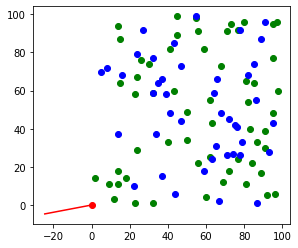

In [27]:
task3_print(xs, ys, np.hstack((np.zeros((xs.shape[1], 1)), task3(xs, ys))) * 25)